In [194]:
# Setup: Add project root to path and import utilities
import sys
sys.path.insert(0, '..')

from utils import get_input

# Load input data for day 9
data = get_input(9, example=False   )

print(f"Loaded {len(data)} lines of input")
print("Sample data:")
for line in data[:10]:
    print(f"  {line}")

# parse data input into list of integer tuples where , is the separator
points = [tuple(map(int, line.split(','))) for line in data]
print(f"Parsed {len(points)} points.")

Loaded 496 lines of input
Sample data:
  97926,50400
  97926,51618
  98025,51618
  98025,52819
  97711,52819
  97711,54079
  98234,54079
  98234,55220
  97394,55220
  97394,56444
Parsed 496 points.


In [195]:
# Use a dictionary to store only the points that exist (sparse representation)
# This is much more memory-efficient for large, sparse grids
grid = {}
for x, y in points:
    grid[(x, y)] = grid.get((x, y), 0) + 1

xMax = max(x for x, y in points)
yMax = max(y for x, y in points)

print(f"Grid spans from (0,0) to ({xMax},{yMax})")


Grid spans from (0,0) to (98234,98094)


In [196]:
def create_boundary_segments(points: list[tuple[int, int]]) -> list[tuple[tuple[int, int], tuple[int, int]]]:
    """
    Create boundary line segments from consecutive points.
    Forms a closed polygon by connecting the last point back to the first.
    
    Args:
        points: List of (x, y) coordinate tuples
        
    Returns:
        List of line segments, each defined by two (x, y) points
    """
    return [(points[i], points[(i + 1) % len(points)]) for i in range(len(points))]
boundary_segments = create_boundary_segments(points)
print(f"Created {len(boundary_segments)} boundary segments.")
print("First 5 boundary segments:")
for segment in boundary_segments[:5]:
    print(f"  {segment}")

Created 496 boundary segments.
First 5 boundary segments:
  ((97926, 50400), (97926, 51618))
  ((97926, 51618), (98025, 51618))
  ((98025, 51618), (98025, 52819))
  ((98025, 52819), (97711, 52819))
  ((97711, 52819), (97711, 54079))


In [197]:
def calculate_distance(point1: tuple[float, float], point2: tuple[float, float]) -> float:
    """Calculate Euclidean distance between two points."""
    x1, y1 = point1
    x2, y2 = point2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def get_polygon_center_and_radius(points: list[tuple[float, float]], error_margin: float = 0.1) -> tuple[tuple[float, float], float]:
    """
    Calculate the centroid of a polygon and the maximum distance from center.
    
    Args:
        points: List of (x, y) coordinate tuples defining the polygon
        error_margin: Percentage to expand the radius (default 10%)
        
    Returns:
        Tuple of (center_point, allowed_radius)
    """
    # Calculate centroid
    xs, ys = zip(*points)
    center = (sum(xs) / len(xs), sum(ys) / len(ys))
    
    # Find maximum distance from center to any vertex
    max_distance = max(calculate_distance(point, center) for point in points)
    
    # Add error margin
    allowed_radius = max_distance * (1 + error_margin)
    
    return center, allowed_radius

def is_rectangle_within_radius(vertices: list[tuple[float, float]], center: tuple[float, float], radius: float) -> bool:
    """
    Check if all rectangle vertices are within the allowed radius from center.
    
    Args:
        vertices: List of rectangle corner coordinates
        center: Center point to measure from
        radius: Maximum allowed distance from center
        
    Returns:
        True if all vertices are within radius, False otherwise
    """
    return all(calculate_distance(vertex, center) <= radius for vertex in vertices)


In [198]:
# Calculate polygon center and allowed radius for optimization
center, allowed_radius = get_polygon_center_and_radius(points, error_margin=0.10)
print(f"Calculated center at {center} with allowed radius {allowed_radius:.2f}")

Calculated center at (50356.13306451613, 49998.41935483871) with allowed radius 54111.71


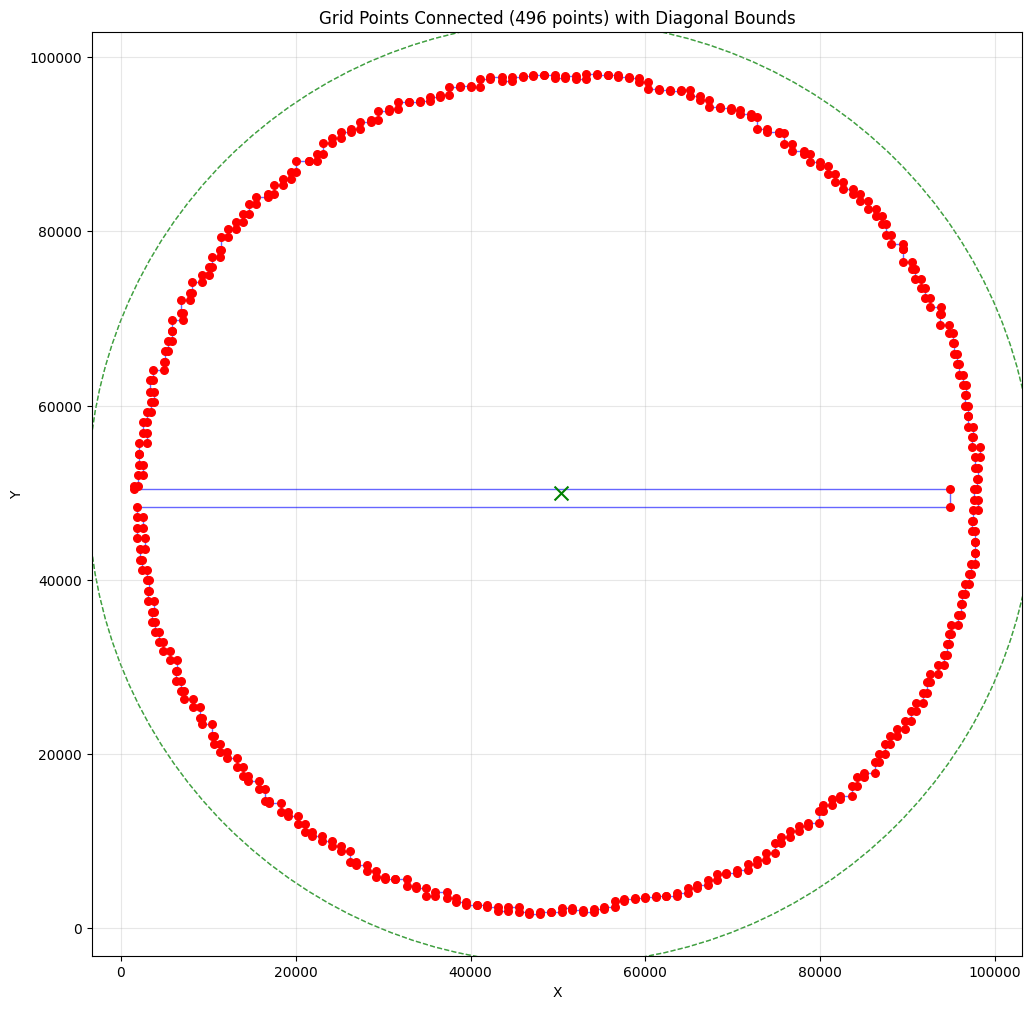

In [199]:
import matplotlib.pyplot as plt

# Extract x and y coordinates from dictionary keys
x_coords = [x for x, y in grid.keys()]
y_coords = [y for x, y in grid.keys()]

# Create plot
plt.figure(figsize=(12, 12))

# Draw lines connecting consecutive points
for point in boundary_segments:
    (x1, y1), (x2, y2) = point
    plt.plot([x1, x2], [y1, y2], 'b-', linewidth=1, alpha=0.6)

# Draw all points
plt.scatter(x_coords, y_coords, marker='o', s=30, c='red', zorder=5, label='Points')

# draw center
plt.scatter([center[0]], [center[1]], marker='x', s=100, c='green', zorder=6, label='Center')
# draw allowed radius circle
circle = plt.Circle(center, allowed_radius, color='green', fill=False, linestyle='--', alpha=0.5, label='Allowed Radius')
plt.gca().add_artist(circle)
plt.gca().add_artist(circle)

plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.title(f'Boundary Polygon ({len(points)} vertices) with Center and Radius Filter')
plt.title(f'Grid Points Connected ({len(points)} points) with Diagonal Bounds')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [200]:
def does_segment_cross_boundary(segment: tuple[tuple[int, int], tuple[int, int]], 
                                 boundary_segments: list[tuple[tuple[int, int], tuple[int, int]]]) -> bool:
    """
    Check if an orthogonal line segment crosses any boundary segment.
    
    Assumes all segments (both input and boundary) are axis-aligned (horizontal or vertical).
    Touching at endpoints or lying on the same line does not count as crossing.
    
    Args:
        segment: Line segment to check, defined by two (x, y) points
        boundary_segments: List of boundary line segments
        
    Returns:
        True if segment crosses any boundary segment, False otherwise
    """
    (x1, y1), (x2, y2) = segment
    seg_min_x, seg_max_x = min(x1, x2), max(x1, x2)
    seg_min_y, seg_max_y = min(y1, y2), max(y1, y2)
    is_vertical = (seg_min_x == seg_max_x)
    
    for boundary_seg in boundary_segments:
        (bx1, by1), (bx2, by2) = boundary_seg
        b_min_x, b_max_x = min(bx1, bx2), max(bx1, bx2)
        b_min_y, b_max_y = min(by1, by2), max(by1, by2)
        b_is_vertical = (b_min_x == b_max_x)
        
        # Vertical segment crossing horizontal boundary
        if is_vertical and not b_is_vertical:
            if b_min_x < seg_min_x < b_max_x and seg_min_y < b_min_y < seg_max_y:
                return True
                
        # Horizontal segment crossing vertical boundary
        elif not is_vertical and b_is_vertical:
            if seg_min_x < b_min_x < seg_max_x and b_min_y < seg_min_y < b_max_y:
                return True
                
    return False

In [201]:
def find_largest_rectangle(
    grid: dict,
    possible_rectangles: list[list[tuple[int, int]]],
    boundary_segments: list[tuple[tuple[int, int], tuple[int, int]]],
    center_and_radius: tuple[tuple[float, float], float] = None
) -> tuple[int, list[tuple[int, int]] | None]:
    """
    Find the largest valid axis-aligned rectangle within a polygon boundary.
    
    A valid rectangle must:
    - Not cross any boundary segments
    - Have all corners on the boundary or inside the polygon
    - Optionally be within a radius from the polygon center
    
    Args:
        grid: Dictionary of boundary points for quick lookup
        possible_rectangles: List of candidate rectangles to check
        boundary_segments: Line segments defining the polygon boundary
        polygon_points: Ordered points defining the polygon
        center_and_radius: Optional (center_point, radius) for filtering
        
    Returns:
        Tuple of (max_area, best_rectangle) or (0, None) if no valid rectangle found
    """
    max_area = 0
    best_rectangle = None
    
    # Statistics for optimizations
    stats = {'radius': 0, 'boundary': 0}
    
    for idx, rect_corners in enumerate(possible_rectangles):
        # Progress reporting
        if idx % 1000 == 0:
            print(f"Progress: {idx:,} / {len(possible_rectangles):,} rectangles checked")
        
        # Calculate rectangle bounds
        xs = [x for x, _ in rect_corners]
        ys = [y for _, y in rect_corners]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        
        # Quick area check - skip if not better than current best
        area = (max_x - min_x) * (max_y - min_y)
        if area <= max_area:
            continue
        
        # Define rectangle properties
        vertices = [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)]
        edges = [
            ((min_x, min_y), (max_x, min_y)),  # Bottom
            ((max_x, min_y), (max_x, max_y)),  # Right
            ((max_x, max_y), (min_x, max_y)),  # Top
            ((min_x, max_y), (min_x, min_y)),  # Left
        ]
        
        # Optimization 1: Check radius constraint (fastest)
        if center_and_radius:
            center, radius = center_and_radius
            if not is_rectangle_within_radius(vertices, center, radius):
                stats['radius'] += 1
                continue
        
        # Optimization 2: Check boundary crossing
        if any(does_segment_cross_boundary(edge, boundary_segments) for edge in edges):
            stats['boundary'] += 1
            continue
        
        # Valid rectangle with better area found!
        max_area = area
        best_rectangle = rect_corners
    
    # Print rejection statistics
    print(f"\nRejection statistics:")
    print(f"  Radius filter: {stats['radius']:,}")
    print(f"  Boundary crossing: {stats['boundary']:,}")
    print(f"  Total checked: {len(possible_rectangles):,}")
    
    return max_area, best_rectangle

In [202]:
def create_possible_rectangles(points: list[tuple[int, int]]) -> list[list[tuple[int, int]]]:
    """
    Generate all possible axis-aligned rectangles using pairs of points as opposite corners.
    
    Args:
        points: List of (x, y) coordinate tuples
        
    Returns:
        List of rectangles, each defined by 4 corner points: [(x1,y1), (x1,y2), (x2,y1), (x2,y2)]
    """
    rectangles = []
    for i, (x1, y1) in enumerate(points):
        for x2, y2 in points[i + 1:]:
            # Create rectangle with these two points as opposite corners
            corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
            rectangles.append(corners)
    return rectangles


In [203]:
possible_rectangles = create_possible_rectangles(points)
print(f"Found {len(possible_rectangles)} possible rectangles.")
# Sort boundary segments by length (longest first) to optimize crossing checks
boundary_segments.sort(key=lambda seg: abs(seg[0][0] - seg[1][0]) + abs(seg[0][1] - seg[1][1]), reverse=True)
print(f"Sorted {len(boundary_segments)} boundary segments by length.")
print(f"Longest segment: {boundary_segments[0]}")
print(f"Second longest: {boundary_segments[1]}")

Found 122760 possible rectangles.
Sorted 496 boundary segments by length.
Longest segment: ((1515, 50375), (94891, 50375))
Second longest: ((94891, 48378), (1889, 48378))


In [204]:
# Find the largest valid rectangle
max_area, final_rect = find_largest_rectangle(
    grid=grid,
    possible_rectangles=possible_rectangles,
    boundary_segments=boundary_segments,
    polygon_points=points,
    center_and_radius=(center, allowed_radius)
)
print(f"\n✓ Search complete! Largest rectangle area: {max_area:,}")


TypeError: find_largest_rectangle() got an unexpected keyword argument 'polygon_points'

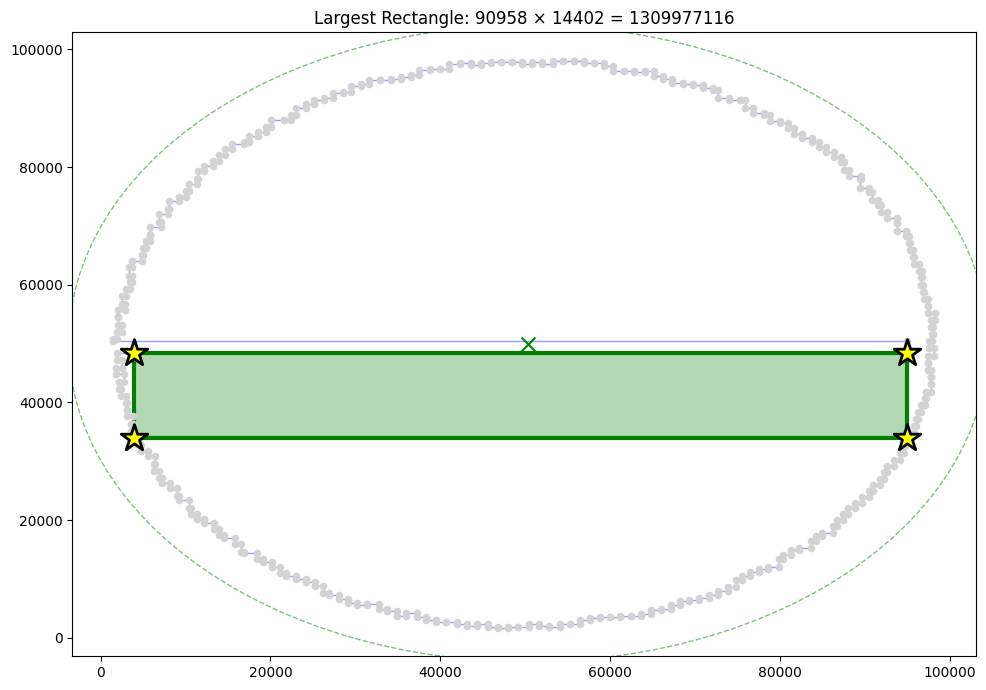

In [ ]:
if final_rect:
    # Extract actual min/max coordinates from the 4 corners
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = final_rect
    min_x = min(x1, x2, x3, x4)
    max_x = max(x1, x2, x3, x4)
    min_y = min(y1, y2, y3, y4)
    max_y = max(y1, y2, y3, y4)
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 7))

    # Plot 1: Winning rectangle
    ax = axes
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-', linewidth=1, alpha=0.4)
    ax.scatter(x_coords, y_coords, marker='o', s=20, c='lightgray', zorder=3)
    
    # Draw the winning rectangle
    rect_x = [min_x, max_x, max_x, min_x, min_x]
    rect_y = [min_y, min_y, max_y, max_y, min_y]
    ax.plot(rect_x, rect_y, 'g-', linewidth=3, label=f'Largest Rectangle (area={max_area})')
    ax.fill(rect_x, rect_y, 'green', alpha=0.3)
    
    # Highlight rectangle corners
    corner_x = [min_x, max_x, min_x, max_x]
    corner_y = [min_y, min_y, max_y, max_y]
    ax.scatter(corner_x, corner_y, marker='*', s=400, c='yellow', edgecolors='black', 
                linewidths=2, zorder=10, label='Rectangle corners')
    
    # show center
    ax.scatter([center[0]], [center[1]], marker='x', s=100, c='green', zorder=6, label='Center')
    # show radius circle
    circle = plt.Circle(center, allowed_radius, color='green', fill=False, linestyle='--', alpha=0.5, label='Allowed Radius')
    ax.add_artist(circle)
    

    ax.set_title(f'Largest Rectangle: {max_x - min_x} × {max_y - min_y} = {max_area}')
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid rectangle found!")

In [ ]:
print(f"Largest rectangle area: {max_area}")

Largest rectangle area: 1309977116
